In [1]:
import requests as rq
import json
import pandas as pd
import numpy as np
from textwrap import wrap
from matplotlib import pyplot as plt
from TCGA_files import *
#from ensembleAPI import geneinfo, genesinfo
from IPython.display import HTML
from sklearn import metrics
from hsbmpy import *

## query many

In [3]:
level = 1
#setup='highlyvariable_colonrectal'
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#label = 'uniq'
L = 3
#labels = ['primary_site', 'disease_type', 'uniq']
labels = ['primary_site', 'secondary_site']
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
#directory = "results/hSBM/%s"%setup
#directory="gtex/hsbm/%s"%setup
#directory = "merged/hsbm"
directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/123experiments/experiment2"
df_clusters = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,L), header=[0])
df_clusters.head()

,Cluster 1,Cluster 2,Cluster 3
0,GTEX-1BAJH-0011-R9b-SM-7,GTEX-U3ZG-0006-SM-47JWX,GTEX-ZYY3-3026-SM-5GIEJ
1,GTEX-16GPK-0011-R1b-SM-7,GTEX-TMMY-0005-SM-33HBN,GTEX-WL46-0011-R11A-SM-3
2,GTEX-15G19-2926-SM-7KUFL,GTEX-13FTW-0005-SM-5LZVZ,GTEX-WHPG-0004-SM-3NMDO
3,GTEX-15G19-0011-R9b-SM-7,GTEX-SSA3-0005-SM-32QOT,GTEX-WHSB-0002-SM-4M1ZR
4,GTEX-15G19-0011-R7b-SM-6,GTEX-T2YK-0005-SM-32QOV,GTEX-1399R-0002-SM-62LD9


In [4]:
#df_files = pd.read_csv("/Users/filippo/Developer/tesi/gtex/files.dat", index_col=[0], header=[0])
#df_files = pd.read_csv("/Users/filippo/Developer/tesi/results/counts/files.dat", index_col=[0], header=[0])
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0])
#df_files.insert(2,'uniq', '')
#for sample in df_files.index.values:
#    row = df_files.loc[sample,:]
#    df_files.at[sample,'uniq']='%s[%s]'%(row['primary_site'],row['disease_type'])
df_files.head()

,primary_site,secondary_site
GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue,Adipose - Subcutaneous
GTEX-111CU-1826-SM-5GZYN,Adipose Tissue,Adipose - Subcutaneous
GTEX-111FC-0226-SM-5N9B8,Adipose Tissue,Adipose - Subcutaneous
GTEX-111VG-2326-SM-5N9BK,Adipose Tissue,Adipose - Subcutaneous
GTEX-111YS-2426-SM-5GZZQ,Adipose Tissue,Adipose - Subcutaneous


error in GTEX-1BAJH-0011-R9b-SM-7
error in GTEX-16GPK-0011-R1b-SM-7
error in GTEX-15G19-2926-SM-7KUFL
error in GTEX-15G19-0011-R9b-SM-7
error in GTEX-15G19-0011-R7b-SM-6
error in GTEX-15ER7-3126-SM-7KUGH
error in GTEX-15ER7-0011-R9b-SM-6
error in GTEX-15ER7-0011-R8a-SM-7
error in GTEX-15ER7-0011-R7a-SM-6
error in GTEX-15ER7-0011-R5b-SM-6
error in GTEX-15EO6-3026-SM-7KUMA
error in GTEX-15EO6-0011-R7a-SM-6
error in GTEX-15EO6-0011-R3b-SM-7
error in GTEX-15DYW-0011-R7a-SM-7


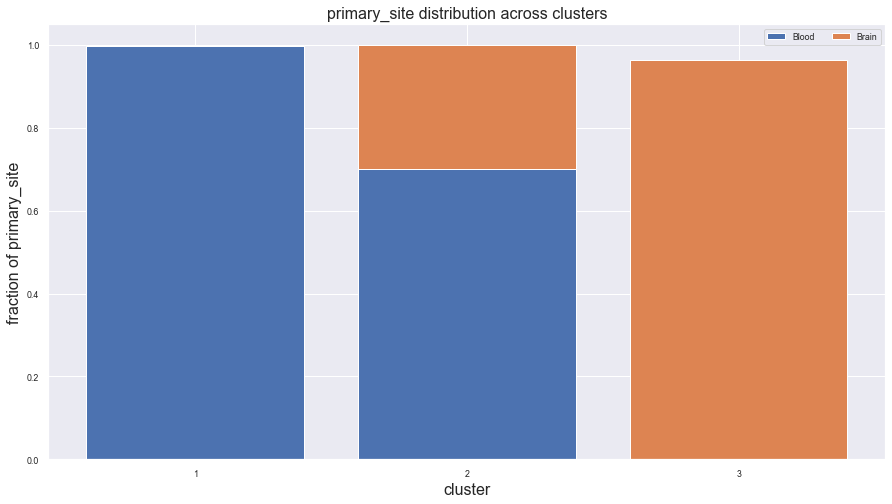

error in GTEX-1BAJH-0011-R9b-SM-7
error in GTEX-16GPK-0011-R1b-SM-7
error in GTEX-15G19-2926-SM-7KUFL
error in GTEX-15G19-0011-R9b-SM-7
error in GTEX-15G19-0011-R7b-SM-6
error in GTEX-15ER7-3126-SM-7KUGH
error in GTEX-15ER7-0011-R9b-SM-6
error in GTEX-15ER7-0011-R8a-SM-7
error in GTEX-15ER7-0011-R7a-SM-6
error in GTEX-15ER7-0011-R5b-SM-6
error in GTEX-15EO6-3026-SM-7KUMA
error in GTEX-15EO6-0011-R7a-SM-6
error in GTEX-15EO6-0011-R3b-SM-7
error in GTEX-15DYW-0011-R7a-SM-7


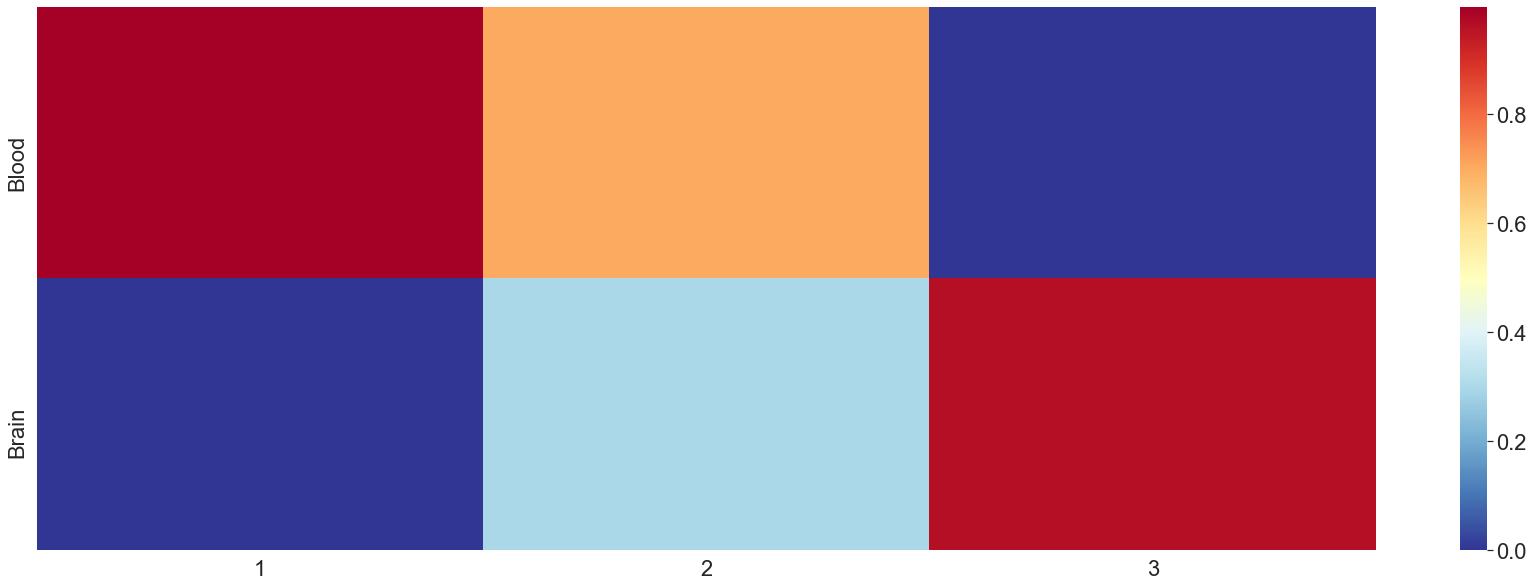

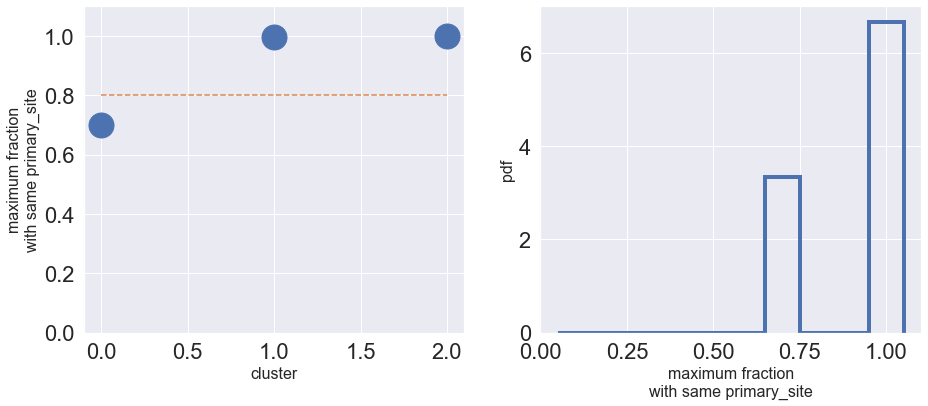

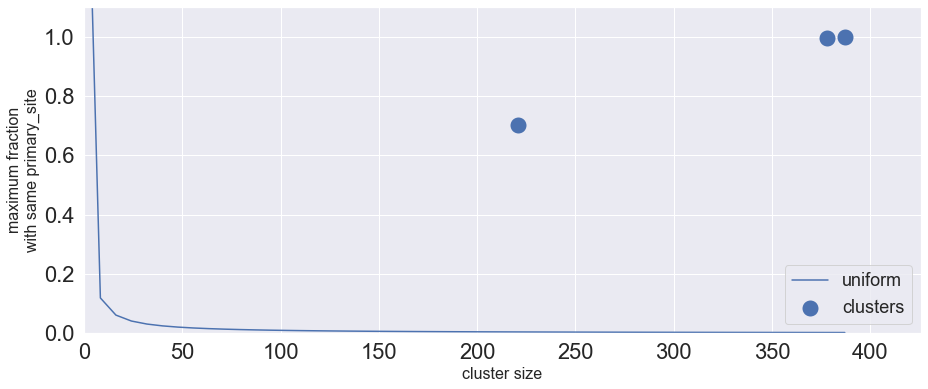

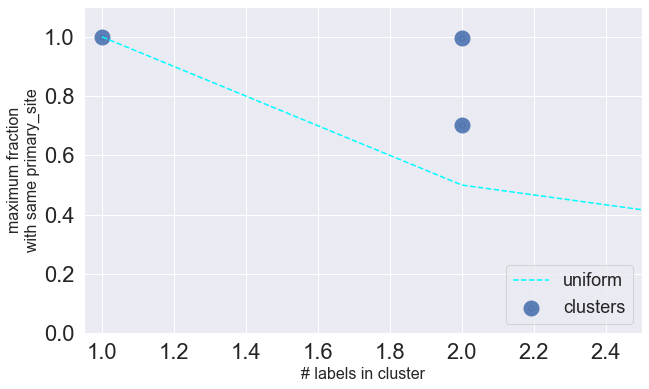

must shuffle files
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-QVUS-0011-R10A-SM-3
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-13112-0011-R3b-SM-5
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-
error in GTEX-R55E-0011-R1A-SM-2T
error in GTEX-14ASI-0011-R10b-SM-
error in GTEX-RNOR-0011-R1A-SM-5S
error in GTEX-131YS-0011-R3b-SM-5
error in GTEX-RNOR-0011-R3A-SM-5S
error in GTEX-132Q8-3026-SM-5PNVG
error in GTEX-147GR-0011-R10b-SM-
error in GTEX-XLM4-0011-R10A-SM-4
error in GTEX-147F4-0011-R10b-SM-
error in GTEX-RU72-3026-SM-5SI7Y
error in GTEX-1399T-0011-R4b-SM-5
error in GTEX-12ZZY-0011-R10b-SM-
error in GTEX-Y8DK-0826-SM-4TT3T
error in GTEX-145MG-0011-R10a-SM-
error in GTEX-QMR6-0011-R10A-SM-3
error in GTEX-14PJO-0011-R10a-SM-
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-14LZ3-3026-SM-5ZZVU
error in GTEX-14JIY-0011-R10a-SM-
error in GTEX-14JG1-3026-SM-5YYAA
error in GTEX-Z93S-0011-R3b-SM-

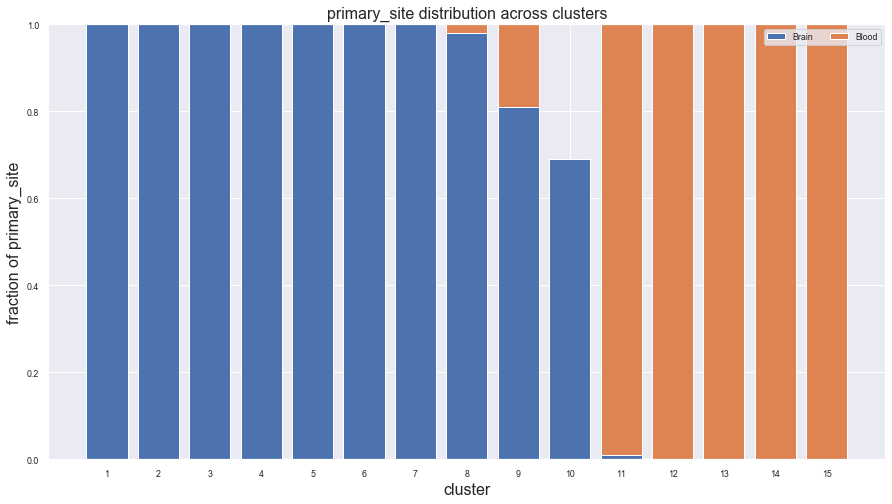

error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-QVUS-0011-R10A-SM-3
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-13112-0011-R3b-SM-5
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-
error in GTEX-R55E-0011-R1A-SM-2T
error in GTEX-14ASI-0011-R10b-SM-
error in GTEX-RNOR-0011-R1A-SM-5S
error in GTEX-131YS-0011-R3b-SM-5
error in GTEX-RNOR-0011-R3A-SM-5S
error in GTEX-132Q8-3026-SM-5PNVG
error in GTEX-147GR-0011-R10b-SM-
error in GTEX-XLM4-0011-R10A-SM-4
error in GTEX-147F4-0011-R10b-SM-
error in GTEX-RU72-3026-SM-5SI7Y
error in GTEX-1399T-0011-R4b-SM-5
error in GTEX-12ZZY-0011-R10b-SM-
error in GTEX-Y8DK-0826-SM-4TT3T
error in GTEX-145MG-0011-R10a-SM-
error in GTEX-QMR6-0011-R10A-SM-3
error in GTEX-14PJO-0011-R10a-SM-
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-14LZ3-3026-SM-5ZZVU
error in GTEX-14JIY-0011-R10a-SM-
error in GTEX-14JG1-3026-SM-5YYAA
error in GTEX-Z93S-0011-R3b-SM-4R
error in GTEX-Z9

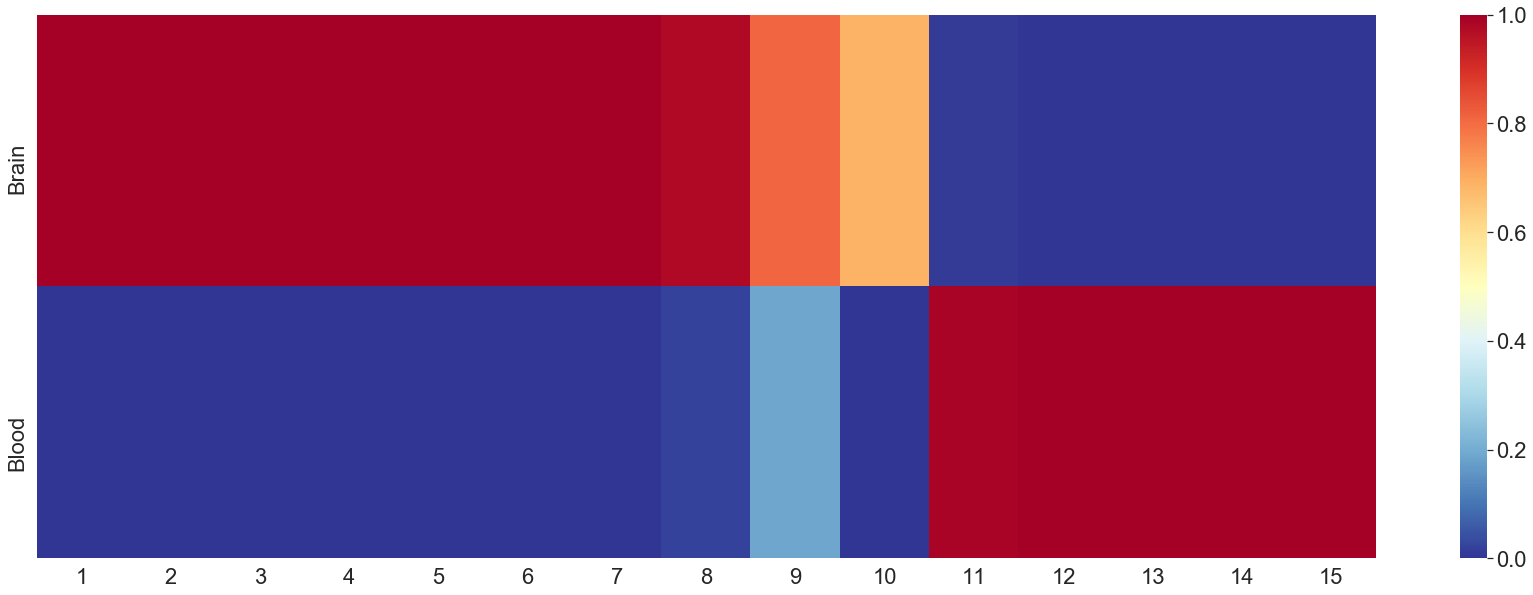

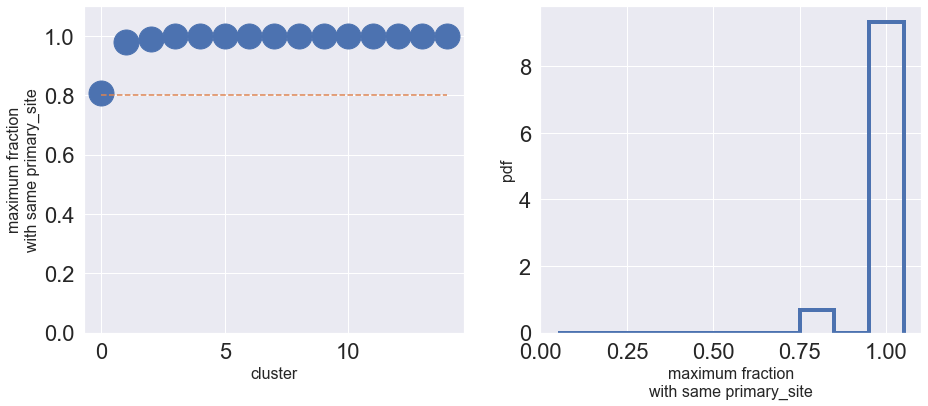

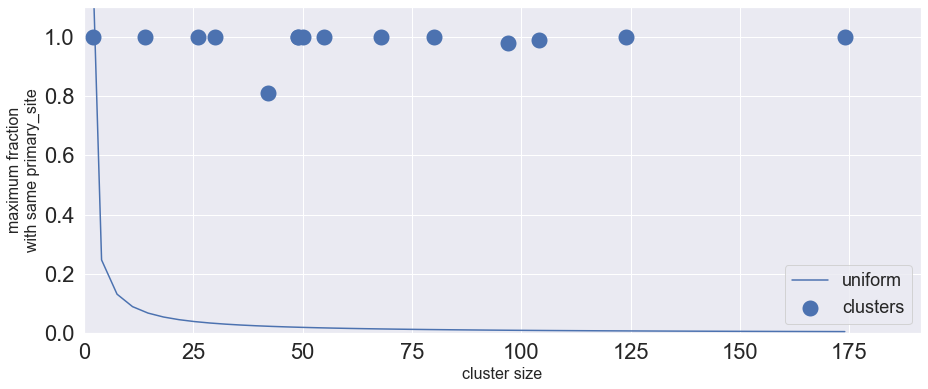

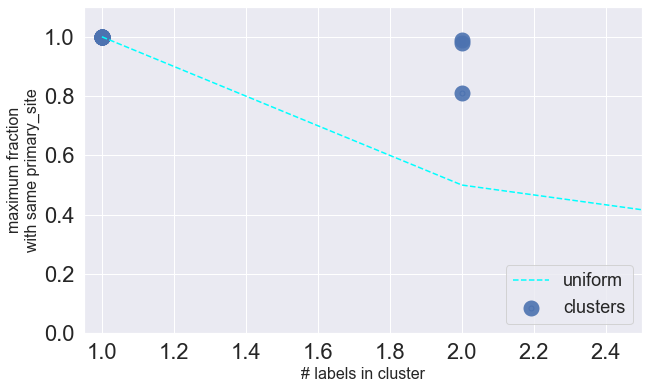

must shuffle files
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-ZUA1-0011-R10a-SM-5
error in GTEX-ZUA1-0011-R3a-SM-4Y
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-3026-SM-3MJG9


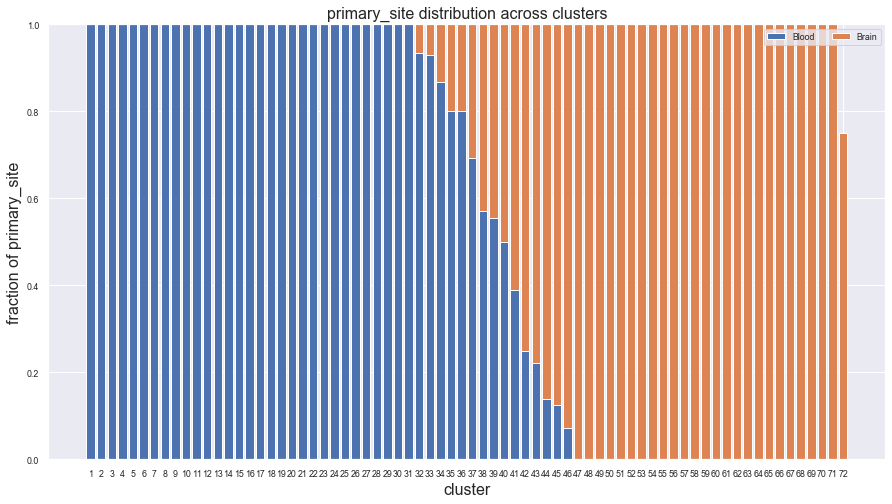

error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-ZUA1-0011-R10a-SM-5
error in GTEX-ZUA1-0011-R3a-SM-4Y
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-3026-SM-3MJG9


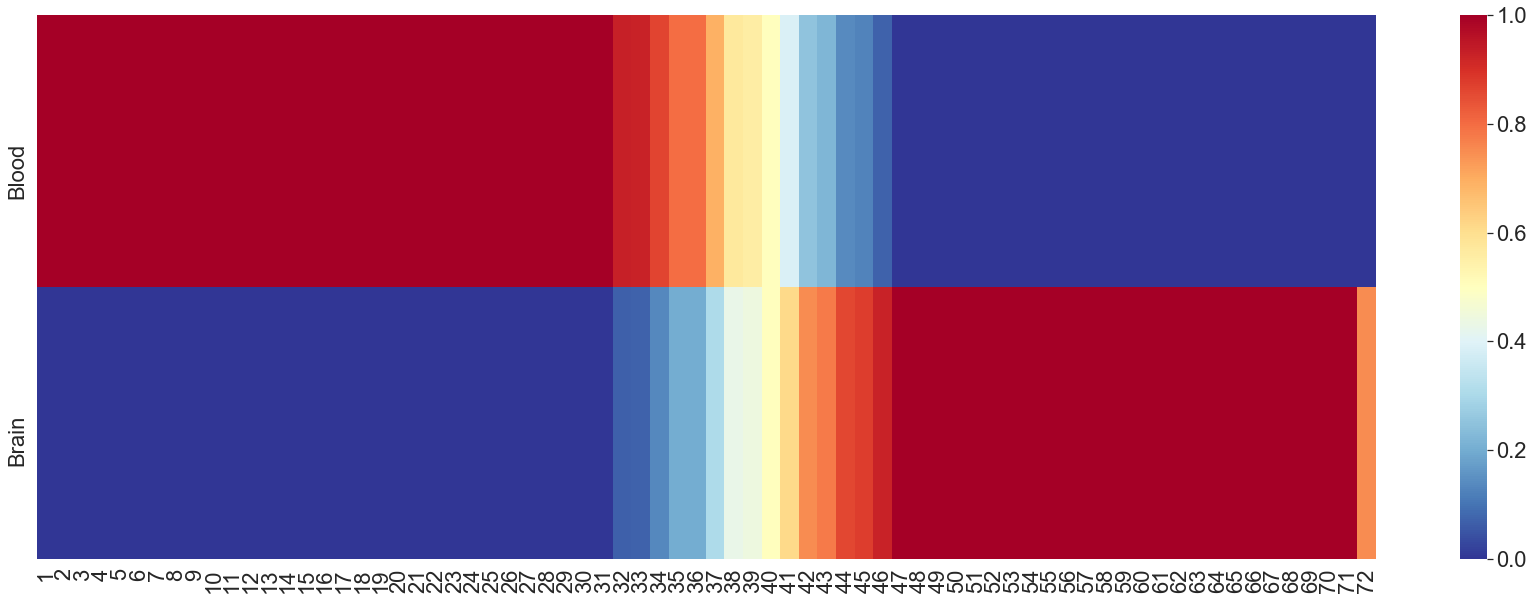

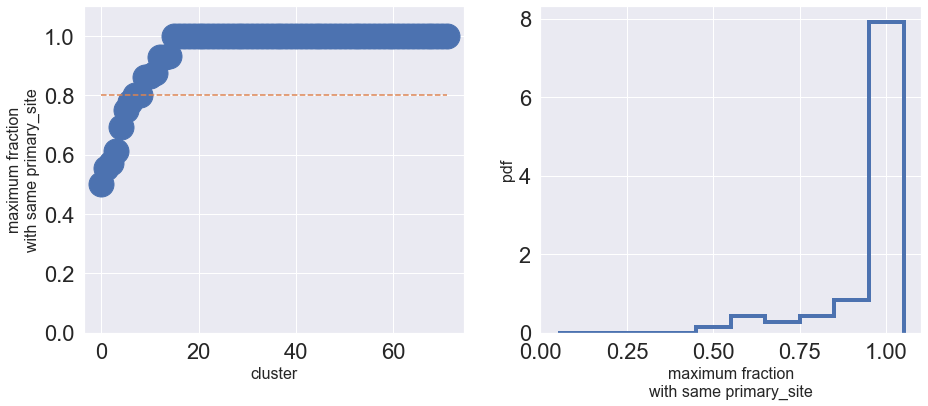

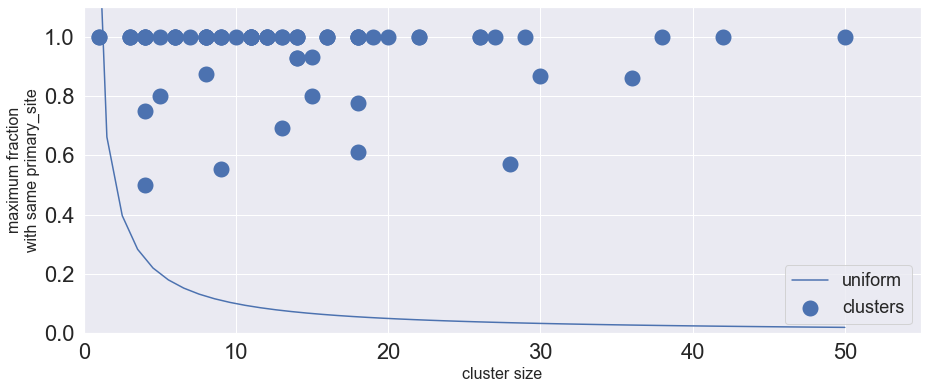

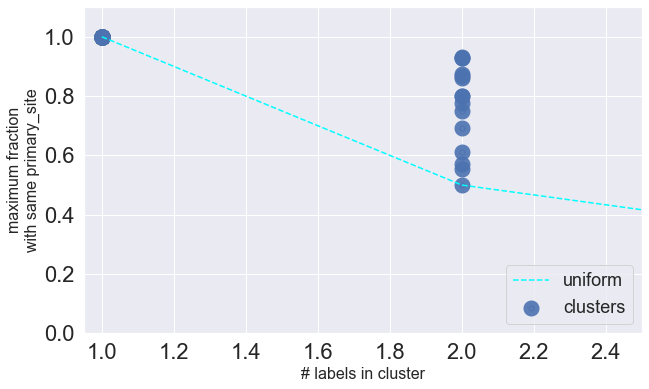

must shuffle files
error in GTEX-1BAJH-0011-R9b-SM-7
error in GTEX-16GPK-0011-R1b-SM-7
error in GTEX-15G19-2926-SM-7KUFL
error in GTEX-15G19-0011-R9b-SM-7
error in GTEX-15G19-0011-R7b-SM-6
error in GTEX-15ER7-3126-SM-7KUGH
error in GTEX-15ER7-0011-R9b-SM-6
error in GTEX-15ER7-0011-R8a-SM-7
error in GTEX-15ER7-0011-R7a-SM-6
error in GTEX-15ER7-0011-R5b-SM-6
error in GTEX-15EO6-3026-SM-7KUMA
error in GTEX-15EO6-0011-R7a-SM-6
error in GTEX-15EO6-0011-R3b-SM-7
error in GTEX-15DYW-0011-R7a-SM-7


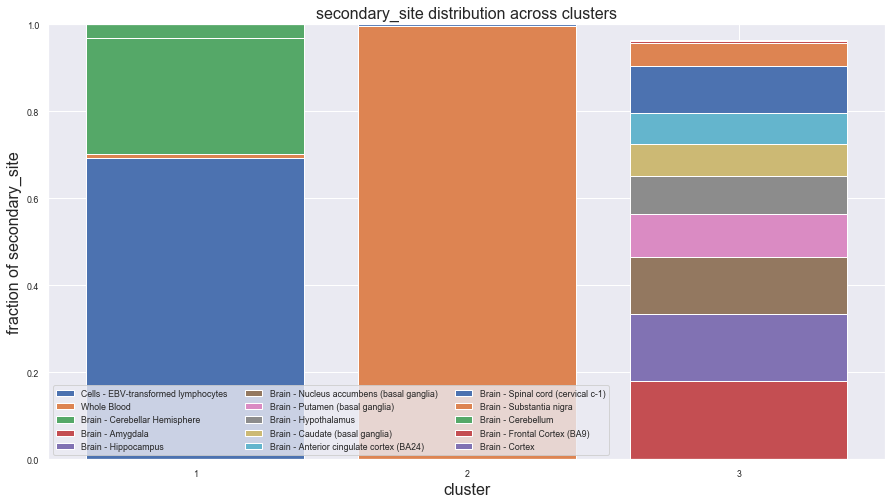

error in GTEX-1BAJH-0011-R9b-SM-7
error in GTEX-16GPK-0011-R1b-SM-7
error in GTEX-15G19-2926-SM-7KUFL
error in GTEX-15G19-0011-R9b-SM-7
error in GTEX-15G19-0011-R7b-SM-6
error in GTEX-15ER7-3126-SM-7KUGH
error in GTEX-15ER7-0011-R9b-SM-6
error in GTEX-15ER7-0011-R8a-SM-7
error in GTEX-15ER7-0011-R7a-SM-6
error in GTEX-15ER7-0011-R5b-SM-6
error in GTEX-15EO6-3026-SM-7KUMA
error in GTEX-15EO6-0011-R7a-SM-6
error in GTEX-15EO6-0011-R3b-SM-7
error in GTEX-15DYW-0011-R7a-SM-7


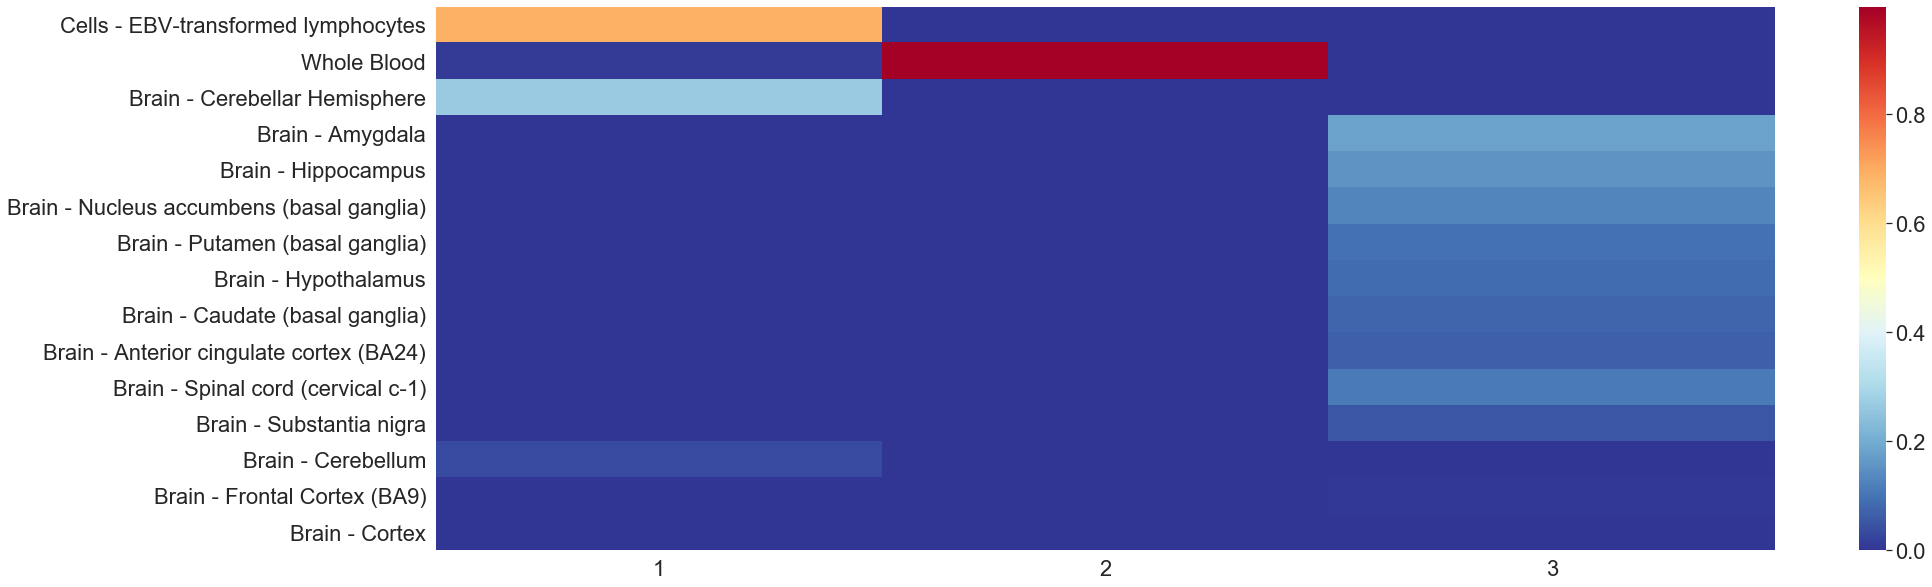

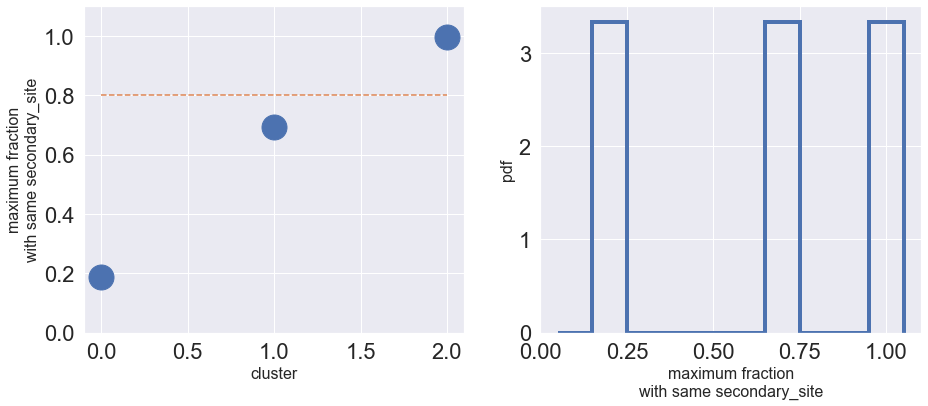

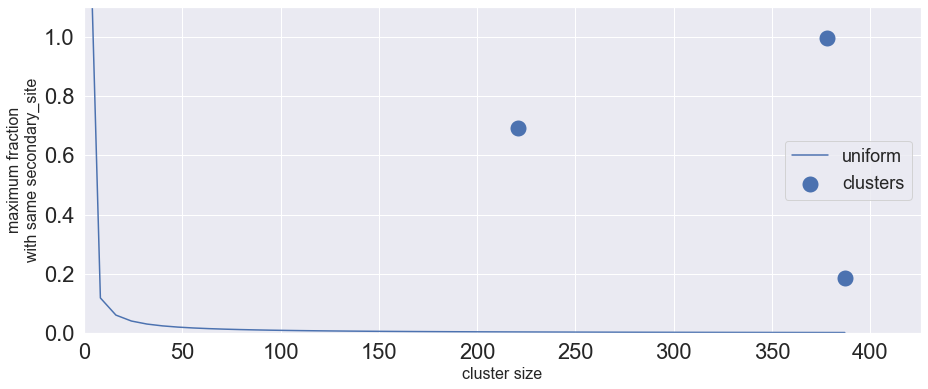

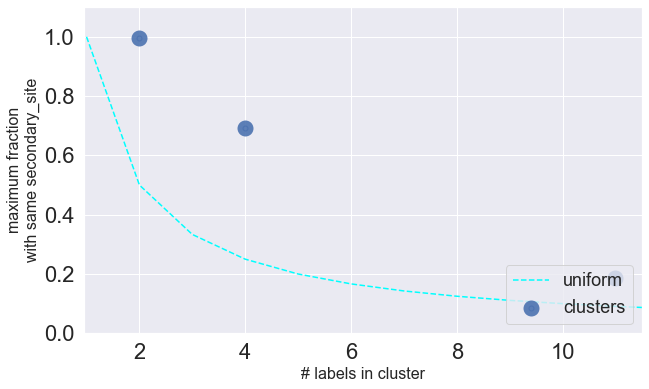

must shuffle files
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-QVUS-0011-R10A-SM-3
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-13112-0011-R3b-SM-5
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-
error in GTEX-R55E-0011-R1A-SM-2T
error in GTEX-14ASI-0011-R10b-SM-
error in GTEX-RNOR-0011-R1A-SM-5S
error in GTEX-131YS-0011-R3b-SM-5
error in GTEX-RNOR-0011-R3A-SM-5S
error in GTEX-132Q8-3026-SM-5PNVG
error in GTEX-147GR-0011-R10b-SM-
error in GTEX-XLM4-0011-R10A-SM-4
error in GTEX-147F4-0011-R10b-SM-
error in GTEX-RU72-3026-SM-5SI7Y
error in GTEX-1399T-0011-R4b-SM-5
error in GTEX-12ZZY-0011-R10b-SM-
error in GTEX-Y8DK-0826-SM-4TT3T
error in GTEX-145MG-0011-R10a-SM-
error in GTEX-QMR6-0011-R10A-SM-3
error in GTEX-14PJO-0011-R10a-SM-
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-14LZ3-3026-SM-5ZZVU
error in GTEX-14JIY-0011-R10a-SM-
error in GTEX-14JG1-3026-SM-5YYAA
error in GTEX-Z93S-0011-R3b-SM-

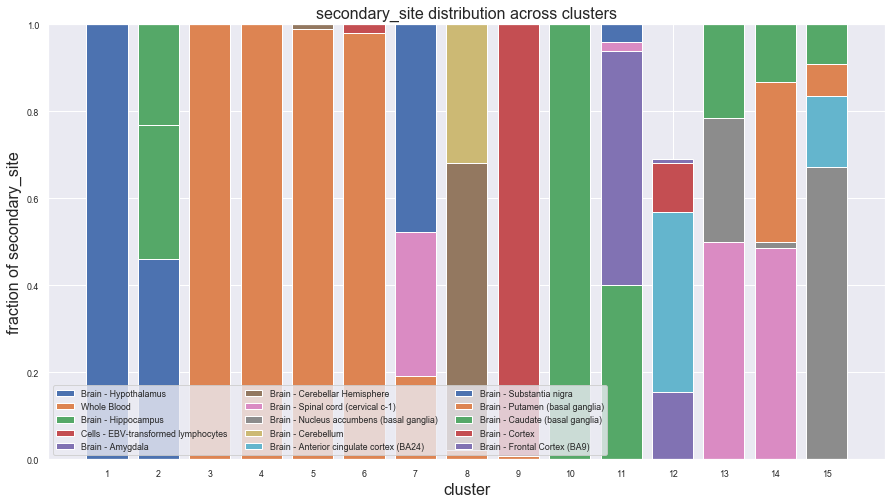

error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-QVUS-0011-R10A-SM-3
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-13112-0011-R3b-SM-5
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-
error in GTEX-R55E-0011-R1A-SM-2T
error in GTEX-14ASI-0011-R10b-SM-
error in GTEX-RNOR-0011-R1A-SM-5S
error in GTEX-131YS-0011-R3b-SM-5
error in GTEX-RNOR-0011-R3A-SM-5S
error in GTEX-132Q8-3026-SM-5PNVG
error in GTEX-147GR-0011-R10b-SM-
error in GTEX-XLM4-0011-R10A-SM-4
error in GTEX-147F4-0011-R10b-SM-
error in GTEX-RU72-3026-SM-5SI7Y
error in GTEX-1399T-0011-R4b-SM-5
error in GTEX-12ZZY-0011-R10b-SM-
error in GTEX-Y8DK-0826-SM-4TT3T
error in GTEX-145MG-0011-R10a-SM-
error in GTEX-QMR6-0011-R10A-SM-3
error in GTEX-14PJO-0011-R10a-SM-
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-14LZ3-3026-SM-5ZZVU
error in GTEX-14JIY-0011-R10a-SM-
error in GTEX-14JG1-3026-SM-5YYAA
error in GTEX-Z93S-0011-R3b-SM-4R
error in GTEX-Z9

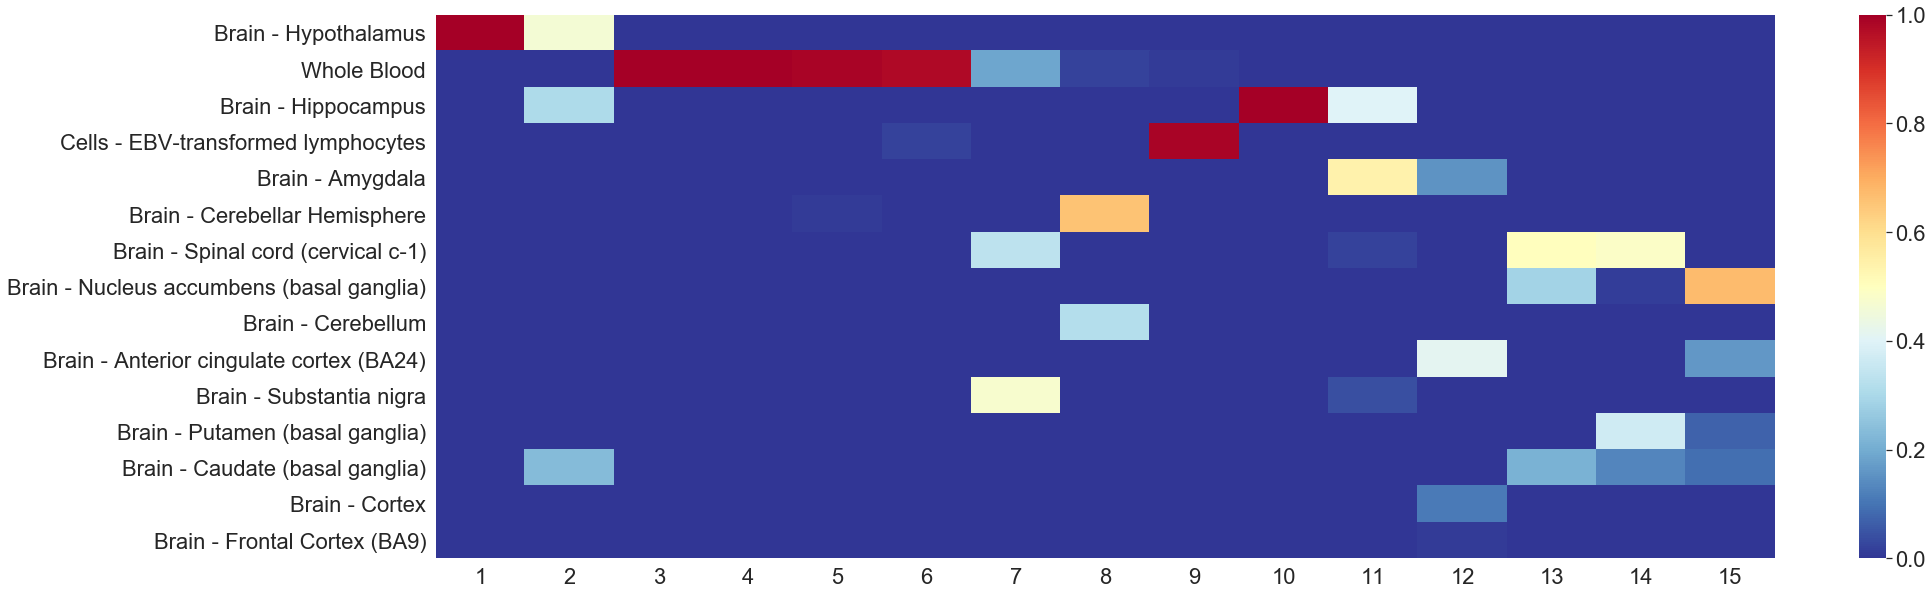

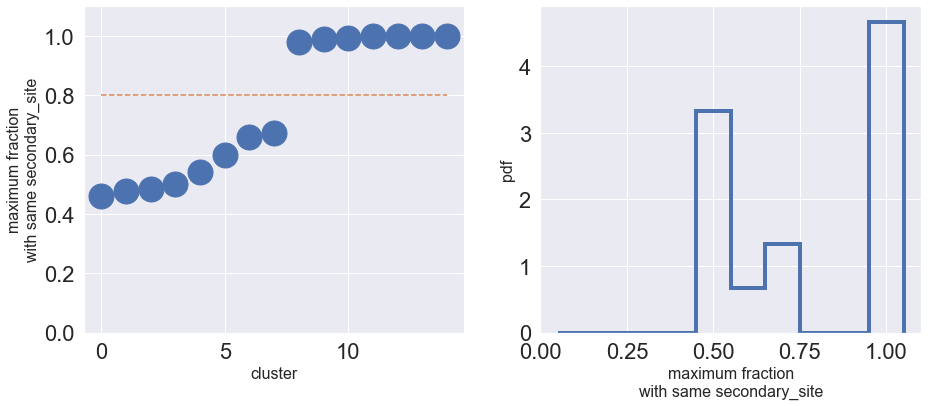

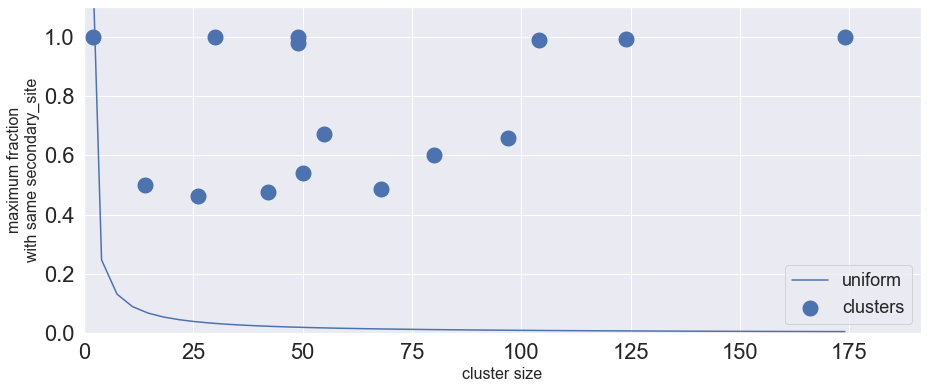

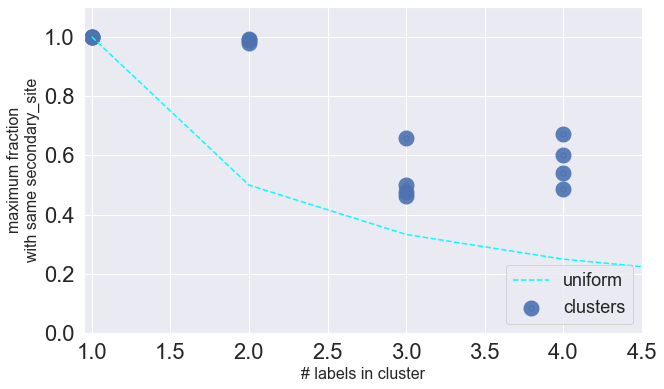

must shuffle files
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-ZUA1-0011-R10a-SM-5
error in GTEX-ZUA1-0011-R3a-SM-4Y
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-3026-SM-3MJG9


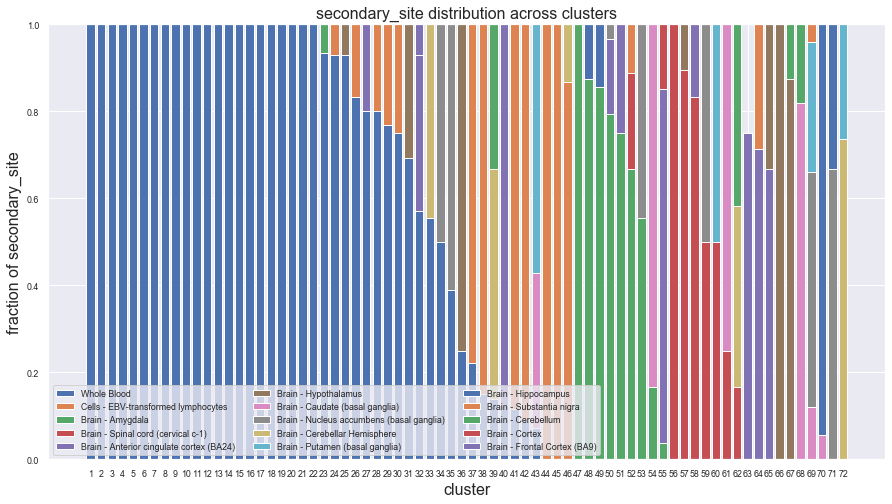

error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-ZUA1-0011-R10a-SM-5
error in GTEX-ZUA1-0011-R3a-SM-4Y
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-3026-SM-3MJG9


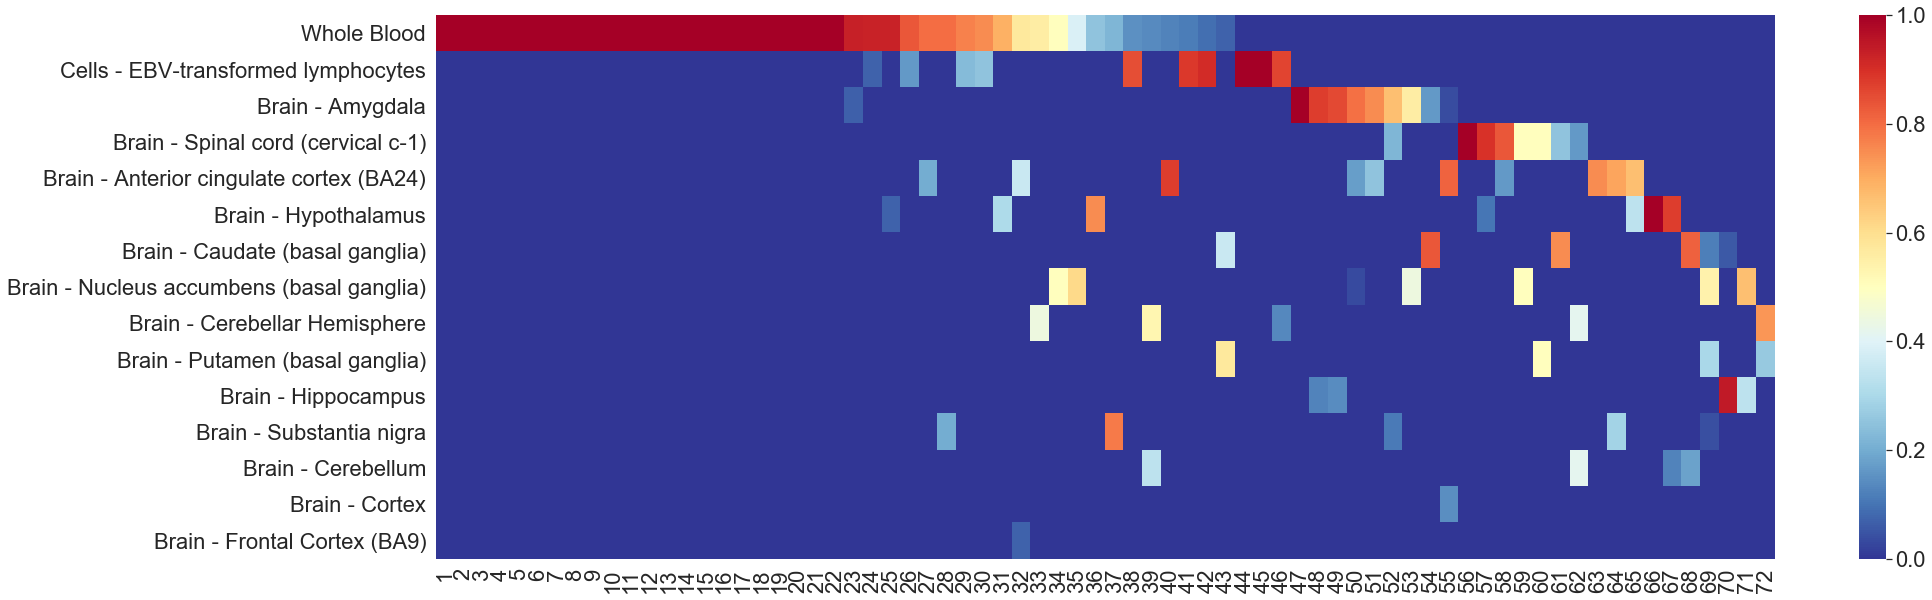

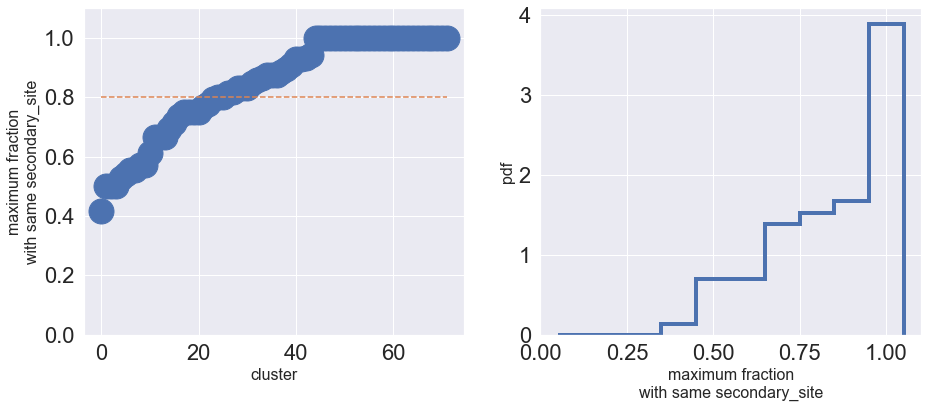

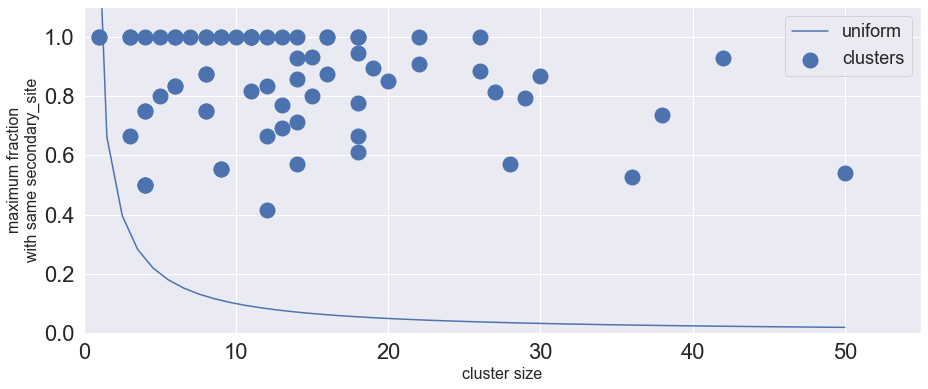

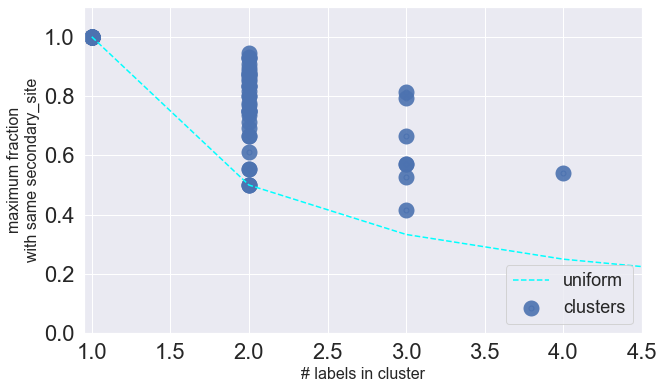

must shuffle files


In [6]:
for label in labels:
    for level in np.arange(L+1)[::-1]:
        if level==0:
            continue
        normalise = True
        cluster = get_cluster_given_l(level, directory)
        fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)
        
        #fsdf = pd.DataFrame(data=fraction_sites)
        #fsdf = fsdf.drop('Other', axis=1)
        #fsdf = fsdf.divide(fsdf.sum(axis=1), axis=0).fillna(0)
        #fraction_sites = fsdf.sort_values(by=fsdf.columns.to_list(), ascending=True).to_dict(orient='list')
        
        clustersinfo = get_clustersinfo(cluster,fraction_sites)
        plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise)
        make_heatmap(fraction_sites, directory, label, level, normalise=normalise)
        
        normalise = False
        cluster = get_cluster_given_l(level, directory)
        fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)
        clustersinfo = get_clustersinfo(cluster,fraction_sites)            
        plot_maximum(clustersinfo,cluster,label,level, directory)
        plot_maximum_size(clustersinfo,label,level, directory)
        plot_maximum_label(clustersinfo,label,level, directory)
        try:
            fraction_sites_shuffle = get_fraction_sites(cluster, pd.read_csv("%s/files.dat.shuf"%directory, index_col=[0]),label=label, normalise=normalise)
            clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
            plot_cluster_composition(fraction_sites_shuffle,directory,level, normalise=False, label=label, shuffled=True)
            plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle)
            plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle)
            plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle)
            plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle)
        except:
            print("must shuffle files")

In [15]:
for l in np.arange(L+1):
    pd.DataFrame(data=define_labels(get_cluster_given_l(l, directory), df_files, label='primary_site')[1], columns=['l%d'%l]).to_csv("~/cluster_%d.csv"%l, header=True, index=False)

In [7]:
scores = {}
for label in labels:
    scores[label]={
        'h':[],
        'c':[],
        'V':[]
    }
    for l in np.arange(L+1):
        try:
            print(l)
            true_labels, predicted_labels = define_labels(get_cluster_given_l(l, directory), df_files, label=label)
            scores[label]['h'].append(metrics.cluster.homogeneity_score(true_labels, predicted_labels))
            scores[label]['c'].append(metrics.cluster.completeness_score(true_labels, predicted_labels))
            scores[label]['V'].append(metrics.cluster.v_measure_score(true_labels, predicted_labels))
        except:
            pass

0
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-111YS-0006-SM-5NQBE
error in GTEX-1122O-0003-SM-5Q5DL
error in GTEX-1128S-2726-SM-5H12C
error in GTEX-117XS-3126-SM-5GIDP
error in GTEX-117YW-0005-SM-5NQ8Z
error in GTEX-1192W-0005-SM-5NQBQ
error in GTEX-11DXX-0005-SM-5NQ8B
error in GTEX-11DXY-0006-SM-5NQ8N
error in GTEX-11DYG-0006-SM-5NQB2
error in GTEX-11EI6-0005-SM-5N9GN
error in GTEX-11EM3-0001-SM-5Q5BD
error in GTEX-11EM3-0005-SM-5N9DK
error in GTEX-11EMC-0002-SM-5Q5DO
error in GTEX-11EMC-0006-SM-5O9DN
error in GTEX-11EQ8-0006-SM-5P9HJ
error in GTEX-11EQ9-0002-SM-5QGQ1
error in GTEX-11GS4-0006-SM-5SI9M
error in GTEX-11GSO-0005-SM-5O9CA
error in GTEX-11GSP-0011-R6b-SM-5
error in GTEX-11GSP-0011-R7b-SM-5
error in GTEX-11GSP-3126-SM-5A5LL
error in GTEX-11GSP-3226-SM-5986O
error in GTEX-11H98-0011-R11b-SM-
error in GTEX-11I78-0001-SM-5Q5BE
error in GTEX-11NSD-0005-SM-5LZZ5
error in GTEX-11NUK-0005-SM-5MR5F
error in GTEX-11NUK-3026-SM-5986K
error in GTEX-11NV4-2226-SM-5BC4T
error in GTE

error in GTEX-WRHK-0005-SM-3MJF5
error in GTEX-WVLH-0006-SM-3MJF7
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-0011-R2A-SM-3M
error in GTEX-WVLH-0011-R5A-SM-3M
error in GTEX-WVLH-3026-SM-3MJG9
error in GTEX-WWTW-0002-SM-4MVNH
error in GTEX-WWYW-0005-SM-3NB3K
error in GTEX-WWYW-0011-R6A-SM-3N
error in GTEX-WWYW-3026-SM-3NB36
error in GTEX-WY7C-0006-SM-3NB3L
error in GTEX-WYBS-0005-SM-4ONDR
error in GTEX-WYJK-0005-SM-3NMA1
error in GTEX-WYVS-0004-SM-4ONDT
error in GTEX-WYVS-0006-SM-3NMA7
error in GTEX-WZTO-0006-SM-3NM9T
error in GTEX-X261-0005-SM-4PQYX
error in GTEX-X261-0011-R10B-SM-4
error in GTEX-X261-0011-R11A-SM-4
error in GTEX-X261-0011-R7A-SM-4E
error in GTEX-X3Y1-0006-SM-3P5ZG
error in GTEX-X4EO-0004-SM-4QARM
error in GTEX-X4EP-0004-SM-4PQZX
error in GTEX-X4EP-0005-SM-3P5ZE
error in GTEX-X4EP-0011-R11B-SM-4
error in GTEX-X4EP-0011-R9B-SM-4Q
error in GTEX-X4EP-3026-SM-3P5YP
error in GTEX-X4LF-0002-SM-4QASG
error in GTEX-X4XX-0011-R10B-SM-4
error in GTEX-X4XX-0011-R2A-SM-3P

error in GTEX-T6MN-0005-SM-32PLJ
error in GTEX-11DYG-0006-SM-5NQB2
error in GTEX-RU72-0006-SM-2TF65
error in GTEX-ZVZQ-0006-SM-51MR8
error in GTEX-WH7G-0002-SM-4LVN9
error in GTEX-11EM3-0001-SM-5Q5BD
error in GTEX-WOFM-0001-SM-4OOT2
error in GTEX-11I78-0001-SM-5Q5BE
error in GTEX-ZLWG-0004-SM-4WWD5
error in GTEX-X5EB-0004-SM-46MWA
error in GTEX-X88G-0004-SM-47JZ6
error in GTEX-ZC5H-0004-SM-4WAXK
error in GTEX-XBEW-0002-SM-4AT5O
error in GTEX-XLM4-0004-SM-4AT5I
error in GTEX-XPT6-0001-SM-4B64G
error in GTEX-XUYS-0002-SM-47JXL
error in GTEX-12WSL-0002-SM-664MF
error in GTEX-11EMC-0002-SM-5Q5DO
error in GTEX-X4LF-0002-SM-4QASG
error in GTEX-ZVT2-0001-SM-57WCK
error in GTEX-WFG8-0001-SM-4LVN8
error in GTEX-ZVTK-0003-SM-51MRV
error in GTEX-147F3-0005-SM-5N9FI
error in GTEX-X3Y1-0006-SM-3P5ZG
error in GTEX-11EM3-0005-SM-5N9DK
error in GTEX-13VXT-0005-SM-5N9F3
error in GTEX-14B4R-0006-SM-5O9A7
error in GTEX-XPT6-0006-SM-4B66Q
error in GTEX-WHSB-0005-SM-3LK7C
error in GTEX-13OVG-0005-SM-5P9HA


error in GTEX-T6MN-0002-SM-3NMAH
error in GTEX-U3ZG-0001-SM-47JYF
error in GTEX-RWS6-0001-SM-3NMAL
error in GTEX-W5WG-0002-SM-3NMDN
error in GTEX-WEY5-0001-SM-3P61Z
error in GTEX-YEC3-0002-SM-4W1YI
error in GTEX-T5JC-0001-SM-3NMAK
error in GTEX-SN8G-0001-SM-3NM8L
error in GTEX-Y9LG-0001-SM-4VBRQ
error in GTEX-T6MO-0003-SM-3NMAG
error in GTEX-ZDTT-0006-SM-4WKFP
error in GTEX-S341-0006-SM-3NM8D
error in GTEX-VUSH-0005-SM-3NB2H
error in GTEX-Y9LG-0006-SM-4VBRK
error in GTEX-WRHK-0005-SM-3MJF5
error in GTEX-S95S-0005-SM-2XCEC
error in GTEX-WY7C-0006-SM-3NB3L
error in GTEX-YF7O-0005-SM-4W1ZU
error in GTEX-XQ3S-0001-SM-4B64K
error in GTEX-S4Q7-0003-SM-3NM8M
error in GTEX-X4EP-0004-SM-4PQZX
error in GTEX-XBEW-0006-SM-4AT4E
2
error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-QVUS-0011-R10A-SM-3
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-13112-0011-R3b-SM-5
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-


error in GTEX-12WSF-0011-R11a-SM-
error in GTEX-12WSH-0011-R11a-SM-
error in GTEX-12ZZZ-0011-R11a-SM-
error in GTEX-Y111-2826-SM-4TT3O
error in GTEX-1313W-3026-SM-5LZUZ
error in GTEX-131XH-0011-R11a-SM-
error in GTEX-XMD1-0011-R11A-SM-4
error in GTEX-XLM4-2926-SM-4AT59
error in GTEX-139UW-0011-R11a-SM-
error in GTEX-X4EP-3026-SM-3P5YP
error in GTEX-X4EP-0011-R11B-SM-4
error in GTEX-TSE9-0011-R11A-SM-3
error in GTEX-12696-3026-SM-5FQTU
error in GTEX-14E6D-2926-SM-664OP
error in GTEX-14JIY-0011-R11b-SM-
error in GTEX-14PJO-2926-SM-686ZI
error in GTEX-14PN4-0011-R11a-SM-
error in GTEX-14PN4-3026-SM-664O4
error in GTEX-OHPN-2626-SM-2I5H1
error in GTEX-15EO6-0011-R11b-SM-
error in GTEX-16YQH-0011-R11b-SM-
error in GTEX-1EWIQ-3026-SM-7IGOJ
error in GTEX-1C6VR-3026-SM-7IGLW
error in GTEX-1B8SF-3026-SM-731DX
error in GTEX-17EVQ-2726-SM-7EWDT
error in GTEX-18465-0011-R11a-SM-
error in GTEX-183WM-2726-SM-7KFRF
error in GTEX-PWO3-1026-SM-2I5F2
error in GTEX-14E6D-0011-R11b-SM-
error in GTEX-13SLX

error in GTEX-12WSE-0011-R6b-SM-5
error in GTEX-13IVO-0011-R3b-SM-5
error in GTEX-13IVO-0011-R5a-SM-5
error in GTEX-13IVO-0011-R6b-SM-5
error in GTEX-13OW6-0011-R7b-SM-5
error in GTEX-13S7M-0011-R10b-SM-
error in GTEX-13RTJ-0011-R7b-SM-5
error in GTEX-13RTJ-0011-R2a-SM-5
error in GTEX-13RTJ-0011-R1a-SM-5
error in GTEX-13RTJ-0011-R10b-SM-
error in GTEX-13QJC-0011-R9b-SM-5
error in GTEX-13QIC-2926-SM-5J2NF
error in GTEX-13PVQ-0011-R9b-SM-5
error in GTEX-13PVQ-0011-R7a-SM-5
error in GTEX-13PL6-0011-R9b-SM-5
error in GTEX-13PDP-0011-R8b-SM-5
error in GTEX-13OW8-0011-R5b-SM-5
error in GTEX-13OW8-0011-R3a-SM-5
error in GTEX-13OW8-0011-R2a-SM-5
error in GTEX-13OW8-0011-R1a-SM-5
error in GTEX-13OW8-0011-R10a-SM-
error in GTEX-13S7M-0011-R5b-SM-5
error in GTEX-13S7M-0011-R9a-SM-5
error in GTEX-13SLW-0011-R2b-SM-5
error in GTEX-13X6K-0011-R10a-SM-
error in GTEX-144GO-0011-R6b-SM-5
error in GTEX-144GL-0011-R7b-SM-5
error in GTEX-1445S-0011-R10a-SM-
error in GTEX-13X6K-2926-SM-5Q5D5
error in GTEX-

error in GTEX-XBEW-0002-SM-4AT5O
error in GTEX-XQ3S-0001-SM-4B64K
error in GTEX-XUYS-0002-SM-47JXL
error in GTEX-XXEK-0004-SM-4BRWO
error in GTEX-XYKS-0002-SM-4BRWN
error in GTEX-12WSC-2926-SM-5BC5Z
error in GTEX-Y111-2826-SM-4TT3O
error in GTEX-XGQ4-0004-SM-4AT5S
error in GTEX-X4EP-0011-R11B-SM-4
error in GTEX-X261-0011-R11A-SM-4
error in GTEX-X4EO-0004-SM-4QARM
error in GTEX-13111-0002-SM-5TDBU
error in GTEX-X4EP-0004-SM-4PQZX
error in GTEX-X4EP-3026-SM-3P5YP
error in GTEX-12WSL-0002-SM-664MF
error in GTEX-X4LF-0002-SM-4QASG
error in GTEX-12ZZZ-0011-R11a-SM-
error in GTEX-X5EB-0004-SM-46MWA
error in GTEX-X88G-0004-SM-47JZ6
error in GTEX-U3ZH-0002-SM-3NMDD
error in GTEX-13FLV-0011-R11a-SM-
error in GTEX-13X6I-2926-SM-5Q5C3
error in GTEX-1C6VR-3026-SM-7IGLW
error in GTEX-1EWIQ-3026-SM-7IGOJ
error in GTEX-147F4-3026-SM-5Q5BJ
error in GTEX-145MI-3126-SM-5Q5CF
error in GTEX-145MG-3126-SM-5Q5D3
error in GTEX-OHPN-2626-SM-2I5H1
error in GTEX-18465-0011-R11a-SM-
error in GTEX-13VXU-0011-R11b

error in GTEX-RNOR-0005-SM-2TF4Z
error in GTEX-RNOR-0011-R1A-SM-5S
error in GTEX-RNOR-0011-R3A-SM-5S
error in GTEX-RNOR-0011-R9A-SM-2T
error in GTEX-RNOR-2226-SM-2TF5O
error in GTEX-RU72-0006-SM-2TF65
error in GTEX-RU72-0011-R11A-SM-5
error in GTEX-RU72-0011-R5A-SM-2T
error in GTEX-RU72-0011-R8A-SM-2T
error in GTEX-RU72-2926-SM-2TF66
error in GTEX-RU72-3026-SM-5SI7Y
error in GTEX-RWS6-0001-SM-3NMAL
error in GTEX-RWS6-0005-SM-2XCAN
error in GTEX-RWSA-0005-SM-2XCAO
error in GTEX-S341-0006-SM-3NM8D
error in GTEX-S4Q7-0003-SM-3NM8M
error in GTEX-S7PM-0006-SM-3NM8C
error in GTEX-S7SE-0005-SM-2XCEA
error in GTEX-S7SE-0011-R10A-SM-2
error in GTEX-S7SE-0011-R2A-SM-2X
error in GTEX-S7SE-0011-R6A-SM-2X
error in GTEX-S7SE-2526-SM-2XCDL
error in GTEX-S95S-0002-SM-3NM8K
error in GTEX-S95S-0005-SM-2XCEC
error in GTEX-SN8G-0001-SM-3NM8L
error in GTEX-SN8G-0006-SM-32PLD
error in GTEX-SNOS-0006-SM-32PLH
error in GTEX-T2IS-0011-R5A-SM-32
error in GTEX-T5JC-0001-SM-3NMAK
error in GTEX-T5JC-0011-R10A-SM-3

error in GTEX-111FC-3126-SM-5GZZ2
error in GTEX-12ZZZ-0011-R10a-SM-
error in GTEX-ZUA1-0011-R10a-SM-5
error in GTEX-ZUA1-0011-R3a-SM-4Y
error in GTEX-WVLH-0011-R10A-SM-3
error in GTEX-WVLH-3026-SM-3MJG9
error in GTEX-Z93S-0011-R10a-SM-4
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-12WSC-3026-SM-5GCNF
error in GTEX-13FTZ-0011-R10b-SM-
error in GTEX-13VXU-2926-SM-5LU5C
error in GTEX-13FHO-0011-R10b-SM-
error in GTEX-WL46-0011-R10A-SM-3
error in GTEX-12ZZX-2926-SM-5GCOQ
error in GTEX-YJ89-0011-R3b-SM-4V
error in GTEX-WHSE-0011-R3A-SM-3P
error in GTEX-Y8DK-0826-SM-4TT3T
error in GTEX-18A6Q-2926-SM-718AR
error in GTEX-18A6Q-0011-R3a-SM-7
error in GTEX-WVLH-0011-R2A-SM-3M
error in GTEX-11ZUS-2926-SM-5FQSL
error in GTEX-13OW7-0011-R10a-SM-
error in GTEX-Z93S-0011-R3b-SM-4R
error in GTEX-X5EB-0006-SM-46MV5
error in GTEX-1211K-0006-SM-5MR53
error in GTEX-Q2AI-0006-SM-2I3FG
error in GTEX-14E6E-0006-SM-5MR5N
error in GTEX-ZVT2-0005-SM-57WBW
error in GTEX-12WSN-0006-SM-5NQAP
error in GTEX-ZVZP-

error in GTEX-17HII-0011-R5a-SM-7
error in GTEX-P44H-0011-R5A-SM-2X
error in GTEX-S7SE-0011-R6A-SM-2X
error in GTEX-N7MT-0011-R5a-SM-2I
error in GTEX-13X6I-0011-R5a-SM-5
error in GTEX-13G51-0011-R5a-SM-5
error in GTEX-14PQA-0011-R5b-SM-6
error in GTEX-12ZZY-0011-R5a-SM-5
error in GTEX-Q2AG-0011-R5A-SM-2H
error in GTEX-14ASI-0011-R5b-SM-6
error in GTEX-RU72-0011-R11A-SM-5
error in GTEX-QMR6-1326-SM-32PLB
error in GTEX-RU72-2926-SM-2TF66
error in GTEX-RNOR-2226-SM-2TF5O
error in GTEX-12ZZZ-0011-R11a-SM-
error in GTEX-13SLX-3226-SM-5YYA6
error in GTEX-13NYS-0011-R11b-SM-
error in GTEX-13SLX-0011-R11b-SM-
error in GTEX-S7SE-2526-SM-2XCDL
error in GTEX-R55E-2526-SM-2TC6H
error in GTEX-13CIG-0011-R8b-SM-5
error in GTEX-18465-0011-R8b-SM-7
error in GTEX-13OW5-0011-R8a-SM-5
error in GTEX-13N1W-0011-R6a-SM-5
error in GTEX-R55E-0011-R8A-SM-2T
error in GTEX-NPJ7-0011-R8a-SM-2I
error in GTEX-1313W-0011-R8a-SM-5
error in GTEX-15ER7-0011-R8a-SM-7
error in GTEX-16XZZ-0011-R8b-SM-7
error in GTEX-X4XY-

error in GTEX-ZC5H-0005-SM-4WAXM
error in GTEX-VJWN-0005-SM-3GIKF
error in GTEX-12696-0005-SM-5LZYS
error in GTEX-11TUW-0006-SM-5LZW2
error in GTEX-14C39-0005-SM-5NQBR
error in GTEX-S7SE-0005-SM-2XCEA
error in GTEX-WFG7-0005-SM-3GIKM
error in GTEX-XMK1-0001-SM-4B64F
error in GTEX-XYKS-0002-SM-4BRWN
error in GTEX-XXEK-0004-SM-4BRWO
error in GTEX-XUYS-0002-SM-47JXL
error in GTEX-12WSJ-0002-SM-5TDBV
error in GTEX-XQ3S-0001-SM-4B64K
error in GTEX-XPT6-0001-SM-4B64G
error in GTEX-12WSL-0002-SM-664MF
error in GTEX-XLM4-0004-SM-4AT5I
error in GTEX-XGQ4-0004-SM-4AT5S
error in GTEX-XBEW-0002-SM-4AT5O
error in GTEX-X88G-0004-SM-47JZ6
error in GTEX-13111-0002-SM-5TDBU
error in GTEX-X5EB-0004-SM-46MWA
error in GTEX-X4LF-0002-SM-4QASG
error in GTEX-X4EP-0004-SM-4PQZX
error in GTEX-X4EO-0004-SM-4QARM
error in GTEX-Y5LM-0003-SM-4V6G1
error in GTEX-YF7O-0004-SM-4W1ZT
error in GTEX-11ZTT-0002-SM-5S2PA
error in GTEX-1269C-0003-SM-5S2PB
error in GTEX-12BJ1-0003-SM-5SI6V
error in GTEX-12C56-0002-SM-5S2PC


error in GTEX-14BIN-3226-SM-62LDR
error in GTEX-14BIM-3026-SM-7EWCY
error in GTEX-14BIM-0011-R3b-SM-5
error in GTEX-14BIL-0011-R10a-SM-
error in GTEX-14ASI-0011-R6a-SM-5
error in GTEX-14ASI-0011-R5b-SM-6
error in GTEX-14ASI-0011-R10b-SM-
error in GTEX-14ABY-0011-R6a-SM-5
error in GTEX-14ABY-0011-R1a-SM-6
error in GTEX-147GR-0011-R9a-SM-5
error in GTEX-147GR-0011-R10b-SM-
error in GTEX-147F4-0011-R10b-SM-
error in GTEX-145MH-0011-R8a-SM-5
error in GTEX-145MH-0011-R7a-SM-5
error in GTEX-145MH-0011-R10b-SM-
error in GTEX-145MG-0011-R10a-SM-
error in GTEX-14BMV-0011-R5b-SM-6
error in GTEX-14C39-0011-R3b-SM-5
error in GTEX-14C5O-0011-R1b-SM-6
error in GTEX-14LZ3-0011-R7a-SM-6
error in GTEX-14PJO-0011-R3a-SM-6
error in GTEX-14PJO-0011-R2a-SM-5
error in GTEX-14PJO-0011-R10a-SM-
error in GTEX-14PJM-0011-R4a-SM-5
error in GTEX-14PJM-0011-R10a-SM-
error in GTEX-14LZ3-3026-SM-5ZZVU
error in GTEX-14DAQ-0011-R3b-SM-5
error in GTEX-14JIY-0011-R6b-SM-6
error in GTEX-14JIY-0011-R5b-SM-6
error in GTEX-

In [ ]:
scores['shuffle']={
        'h':[],
        'c':[],
        'V':[]
    }
for l in np.arange(0,L+1):
    print(l)
    _, predicted_labels = define_labels(get_cluster_given_l(l, directory), df_files, label='primary_site')
    true_labels, _ = define_labels(get_cluster_given_l(l,directory), pd.read_csv("%s/files.dat.shuf"%directory, index_col=[0]),label='primary_site')
    scores['shuffle']['h'].append(metrics.cluster.homogeneity_score(true_labels, predicted_labels))
    scores['shuffle']['c'].append(metrics.cluster.completeness_score(true_labels, predicted_labels))
    scores['shuffle']['V'].append(metrics.cluster.v_measure_score(true_labels, predicted_labels))
    

In [8]:
xl = [len(get_cluster_given_l(li,directory)) for li in np.linspace(1,L,L)]
with open("%s/clustersizes.txt"%directory,'w') as f:
    for x in xl:
        f.write("%d\n"%x)

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

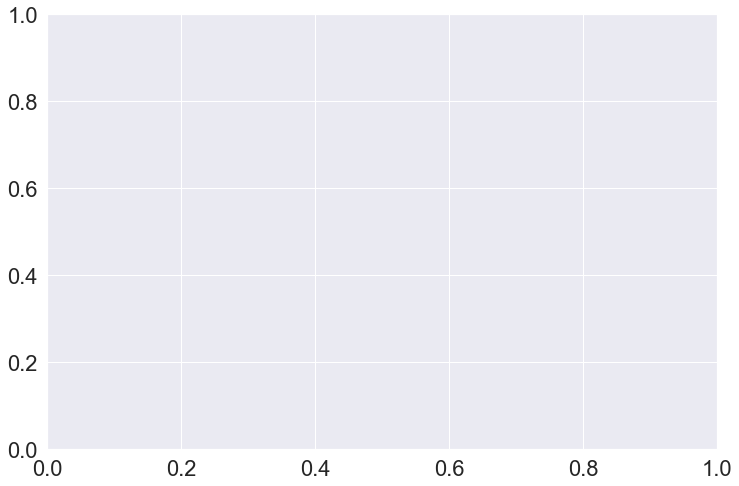

In [9]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,['primary_site'],xl, h=True, c=True, alpha=1)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

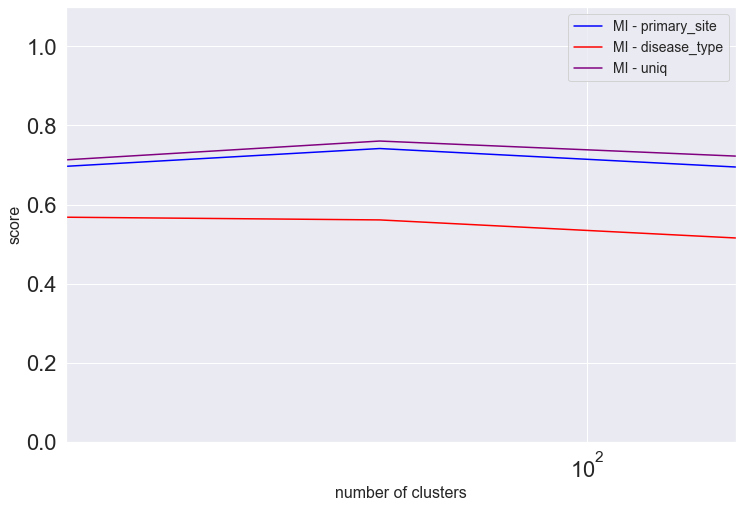

In [23]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels,xl)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores.pdf"%(directory))

In [25]:
h = np.array(scores['primary_site']['h'])
c = np.array(scores['disease_type']['c'])
scores['mixed'] = {
    'h':h,
    'c':c,
    'V':2*h*c/(h+c)
}

KeyError: 'shuffle'

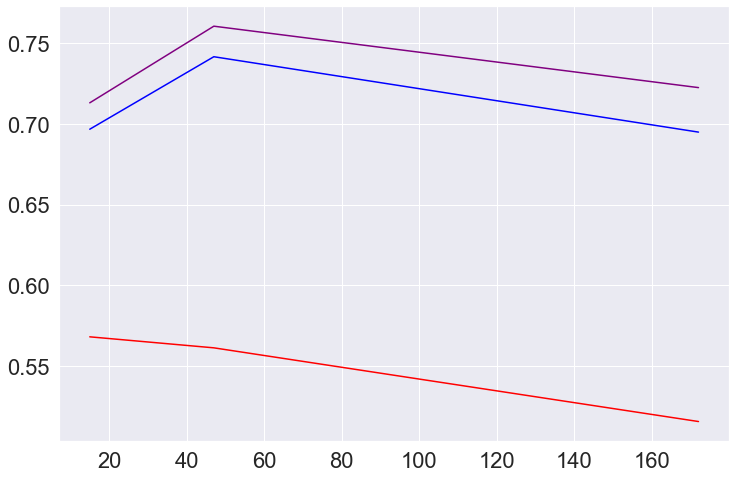

In [26]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,np.concatenate((labels,['shuffle','mixed'])),xl)
plt.show()
fig.savefig("%s/metric_scores_shuffle.pdf"%(directory))

In [ ]:
scores['hierarchical'] = pd.read_csv("%s/hierarchical.scores"%directory).to_dict(orient='list')

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,np.concatenate((labels,['shuffle','hierarchical'])),xl)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores_hier.pdf"%(directory))

In [ ]:
scores['lda'] = pd.read_csv("%s/lda.scores"%directory).to_dict(orient='list')

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,['mixed','hierarchical','shuffle','lda'],xl, lw=2)
plt.show()
fig.savefig("%s/metric_scores_all.pdf"%(directory))

# Benchmark
https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
true_labels = []
predicted_labels = []
for c in cluster:
    print(c)
    for sample in cluster[c]:
        #true_labels.append(getFile(sample)['primary_site'].values[0])
        try:
            true_labels.append(df_files.loc[sample][label])
            predicted_labels.append(c)
        except:
            print("error in %s"%sample)

In [ ]:
_, labels_true = np.unique(true_labels,return_inverse=True)

In [ ]:
series_metrics=pd.Series(name=setup+'__level_%d_%s'%(level,label))
series_metrics['MI']=metrics.cluster.normalized_mutual_info_score(labels_true, predicted_labels, average_method='arithmetic')
series_metrics['Homogeneity']=metrics.cluster.homogeneity_score(labels_true, predicted_labels) 
series_metrics['Completness']=metrics.cluster.completeness_score(labels_true, predicted_labels) 
series_metrics['Vmeasure']=metrics.cluster.v_measure_score(labels_true, predicted_labels)
series_metrics['Fowlkes-Mallows']=metrics.cluster.fowlkes_mallows_score(labels_true,predicted_labels)
series_metrics['AdjustedRandIndex']=metrics.cluster.adjusted_rand_score(labels_true,predicted_labels)

In [ ]:
series_metrics

In [ ]:
#df_metrics = pd.DataFrame(columns=['AdjustedRandIndex','MI','Homogeneity','Completness','Vmeasure','Fowlkes-Mallows'])

In [ ]:
try:
    df_metrics.append(series_metrics, ignore_index=False, verify_integrity=True).to_csv("results/hSBM/metrics.csv", index=True,header=True)
except:
    raise

In [ ]:
df_metrics = pd.read_csv("results/hSBM/metrics.csv", index_col=[0],header=[0])
df_metrics.sort_values(by=['MI','Homogeneity'], ascending=False, axis=0, inplace=True)
df_metrics.round(decimals=2)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(24, 20)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = pd.plotting.table(ax, df_metrics.round(decimals=2), loc='upper right', colWidths=[0.12]*len(df_metrics.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1, 2) # change size table
plt.savefig('results/hSBM/metrics.pdf', transparent=True)

In [ ]:
metrics.cluster.contingency_matrix(true_labels, predicted_labels)

In [ ]:
df_files[df_files['primary_site']=='Brain']